In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
from copy import deepcopy

In [3]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

mnist = load_digits()
X = mnist.data
y = mnist.target

In [4]:
X[0], X[0].shape

(array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
        15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
        12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
         0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
        10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.]), (64,))

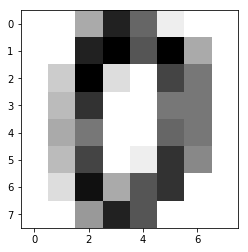

In [5]:
plt.imshow(mnist.images[0], cmap='gray_r');

In [6]:
class LogisticRegression:
    
    """Logistic regression for classification."""
    
    def __init__(self, l, w_shape=2):
        rnd = np.random.RandomState(123)
        self.l = l
        
        self.W = rnd.normal(0, 1, w_shape)
        self.w0 = rnd.normal(0, 1, 1)
        
        # two lists for keeping track of 
        # all updated weights and biases
        self.weights = []
        self.biases = []
        
        self.errs = []
        
        self.steps_count = 0

    def train(self, X, T, max_steps=3, n_similar_loss=20, similar_loss_value=0.2):
        
        self.max_steps = max_steps
        self.n_similar_loss = n_similar_loss
        self.similar_loss_value = similar_loss_value
        
        for step in range(max_steps):
            self.steps_count += 1
            if self.__iter_over_data(X, T, n_similar_loss, similar_loss_value): 
                break

    def predict(self, x):
        return self.__sigmoid(self.W.T.dot(x) + self.w0).round()[0]
        
    def predict_all(self, y_train):
        return np.array([self.predict(y) for y in y_train])
    
    def score(self, y_train, y_test):
        return np.sum((self.predict_all(y_train) == y_test)) / len(y_train)
    
    def __iter_over_data(self, X, T, n_similar_loss, similar_loss_value):
        for x, t in zip(X, T):
            pred = self.__sigmoid(self.W.T.dot(x) + self.w0)[0]
            loss = self.__loss(pred, t)
            
            if len(self.errs) >= n_similar_loss:
                past_loss_dif = np.array(self.errs[-n_similar_loss:]) - loss
                if(np.all(past_loss_dif >= 0) 
                    and 
                   np.all(past_loss_dif < similar_loss_value)):
                    return True
            
            self.errs.append(loss)
            self.__grad(x, pred, t)
    
    def __loss(self, y, t):
        return -(t * np.log(y) + (1 - t) * np.log(1 - y))
    
    def __sigmoid(self, x):
        sigm_x = 1 / (1 + np.exp(-x))
        rnd_num = np.random.uniform(000.1, 0.1)
        if sigm_x == 1.0:
            return sigm_x - rnd_num
        elif sigm_x == 0.0:
            return sigm_x + rnd_num
        else:
            return sigm_x
    
    def __grad(self, x, predict, target):
        self.weights.append(self.W.copy())
        self.biases.append(self.w0.copy())
        self.w0 -= self.l * (predict - target)
        self.W -= self.l * (predict - target) * x
        
    def hyperparams(self):
        return dict(l=self.l,
                max_steps=self.max_steps,
                n_similar_loss=self.n_similar_loss,
                similar_loss_value=self.similar_loss_value)

In [7]:
def get_possible_combinations(param_grid):
    
    param_names = [key for params in param_grid for (key, _) in params.items()]
    param_values = [value for params in param_grid for (_, value) in params.items()]

    values = list(product(*param_values))
    params = [param_names for _ in range(len(values))]

    possible_params = []

    for param in zip(params, values):
        param_dict = {}
        for name, value in zip(*param):
            param_dict[name] = value
        possible_params.append(param_dict)
    return possible_params

In [8]:
def find_best_model(model, X, y, hyper_param_list, folds=5):
    models_and_scores = []
    fold_size = len(X) // folds
    
    # cross validation
    for fold in range(folds):
        mask = np.ones(len(X), dtype=bool)
        mask[fold_size * fold: fold_size * (fold + 1)] = False
        
        X_train_, y_train_, X_test_, y_test_ = X[mask], X[~mask], y[mask], y[~mask]
        
        models = []
        for i in range(len(hyper_param_list)):
            mode = deepcopy(model)
            mode.train(X_train_, X_test_, **hyper_param_list[i])
            models.append(mode)
        
        models_and_scores.extend([
            (model, model.score(y_train_, y_test_))
            for model in models
        ])
    best_model_index = np.argmax(np.array(models_and_scores)[:, 1])
    return models_and_scores[best_model_index]

In [9]:
def choose_numbers(dig1, dig2):
    c0 = X[np.where(y == dig1)]
    c1 = X[np.where(y == dig2)]

    l0 = np.zeros(len(y[np.where(y == dig1)]))
    l1 = np.ones(len(y[np.where(y == dig2)]))
    
    data = np.concatenate((c0, c1))
    labels = np.concatenate((l0, l1))
    
    return data, labels

data, labels = choose_numbers(0, 1)

In [10]:
from sklearn.model_selection import train_test_split

X_train, y_train, X_test, y_test = train_test_split(
                                            data, 
                                            labels, 
                                            test_size=0.3, 
                                            random_state=12)

In [11]:
param_grid = [{'n_similar_loss': [3, 5, 15, 20, 30], 'similar_loss_value': [0.2, 0.4, 0.6, 0.9, 1.3]}]

hyper_params = get_possible_combinations(param_grid)
hyper_params[:5]

[{'n_similar_loss': 3, 'similar_loss_value': 0.2},
 {'n_similar_loss': 3, 'similar_loss_value': 0.4},
 {'n_similar_loss': 3, 'similar_loss_value': 0.6},
 {'n_similar_loss': 3, 'similar_loss_value': 0.9},
 {'n_similar_loss': 3, 'similar_loss_value': 1.3}]

In [12]:
best_model, best_score = find_best_model(
                            LogisticRegression(l=0.2, w_shape=X_train.shape[1]), 
                            X_train, 
                            X_test, 
                            hyper_params)
best_model, best_score

(<__main__.LogisticRegression at 0x1a17c274a8>, 1.0)

In [16]:
# best hyperparams
best_model.hyperparams()

{'l': 0.2, 'max_steps': 3, 'n_similar_loss': 3, 'similar_loss_value': 0.2}

In [517]:
print('Best model accuracy score on test data:', best_model.score(y_train, y_test))

Best model accuracy score on test data: 1.0


In [518]:
# quick test
random_indexes = np.random.randint(len(y_train), size=10)
for y, t in zip(np.array(y_train)[random_indexes], np.array(y_test)[random_indexes]):
    pred = best_model.predict(y)
    print(f'Pred : {pred}, Target : {t}')

Pred : 1.0, Target : 1.0
Pred : 1.0, Target : 1.0
Pred : 0.0, Target : 0.0
Pred : 1.0, Target : 1.0
Pred : 0.0, Target : 0.0
Pred : 1.0, Target : 1.0
Pred : 1.0, Target : 1.0
Pred : 0.0, Target : 0.0
Pred : 0.0, Target : 0.0
Pred : 1.0, Target : 1.0


In [519]:
# for other numbers

X = mnist.data
y = mnist.target

data, labels = choose_numbers(4, 9)

X_train, y_train, X_test, y_test = train_test_split(
                                            data, 
                                            labels, 
                                            test_size=0.3, 
                                            random_state=12)

In [520]:
param_grid = [{'n_similar_loss': [3, 5, 15, 20, 30], 'similar_loss_value': [0.2, 0.4, 0.6, 0.9, 1.3]}]

hyper_params = get_possible_combinations(param_grid)

best_model, best_score = find_best_model(
                            LogisticRegression(l=0.2, w_shape=X_train.shape[1]), 
                            X_train, 
                            X_test, 
                            hyper_params)

best_model, best_score

(<__main__.LogisticRegression at 0x7f40acbf9da0>, 1.0)

In [521]:
best_model.hyperparams()

{'l': 0.2, 'max_steps': 3, 'n_similar_loss': 30, 'similar_loss_value': 0.2}

In [522]:
print('Best model accuracy score on test data:', best_model.score(y_train, y_test))

Best model accuracy score on test data: 0.9908256880733946
